<a href="https://colab.research.google.com/github/medayoubaziz/sales-predictions/blob/main/sales_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
name_file = '/content/sales_predictions_2023.csv'
df = pd.read_csv(name_file)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [35]:
df.shape

(8523, 12)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [37]:
df.duplicated().sum()

0

In [38]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [39]:
df['Outlet_Size'].duplicated().value_counts(normalize = True)

True     0.999531
False    0.000469
Name: Outlet_Size, dtype: float64

In [40]:
#it's less than 2% so we should drop them
df.dropna(subset=['Outlet_Size'], inplace=True)
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [41]:
df['Item_Weight'].duplicated().value_counts(normalize = True)

True     0.93293
False    0.06707
Name: Item_Weight, dtype: float64

In [42]:
df.groupby('Item_Fat_Content')['Item_Weight'].mean()

Item_Fat_Content
LF         12.868672
Low Fat    13.036929
Regular    12.687930
low fat    12.234245
reg        12.742817
Name: Item_Weight, dtype: float64

In [43]:
df.replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}, inplace=True)

In [44]:
df.groupby('Item_Fat_Content')['Item_Weight'].mean()

Item_Fat_Content
Low Fat    13.012853
Regular    12.690298
Name: Item_Weight, dtype: float64

In [45]:
df['Item_Fat_Content'].value_counts()

Low Fat    3955
Regular    2158
Name: Item_Fat_Content, dtype: int64

In [46]:
low = df['Item_Fat_Content'] == 'Low Fat'
mean_low = df.loc[low,'Item_Weight'].mean(skipna=True)
df[low].isna().sum()

Item_Identifier                0
Item_Weight                  951
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                    0
Outlet_Location_Type           0
Outlet_Type                    0
Item_Outlet_Sales              0
dtype: int64

In [47]:
reg = df['Item_Fat_Content'] == 'Regular'
mean_reg = df.loc[reg, 'Item_Weight'].mean(skipna=True)
df[reg].isna().sum()

Item_Identifier                0
Item_Weight                  512
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                    0
Outlet_Location_Type           0
Outlet_Type                    0
Item_Outlet_Sales              0
dtype: int64

In [48]:
def fill_missing_reg() :
  for miss in df[reg>0] :
    df[miss].fillna(mean_reg, inplace=True)


In [49]:
def fill_missing_low() :
  for miss in df[low>0] :
    df[miss].fillna(mean_low, inplace=True)

In [50]:
fill_missing_reg()
fill_missing_low()

In [51]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6113 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            6113 non-null   object 
 1   Item_Weight                6113 non-null   float64
 2   Item_Fat_Content           6113 non-null   object 
 3   Item_Visibility            6113 non-null   float64
 4   Item_Type                  6113 non-null   object 
 5   Item_MRP                   6113 non-null   float64
 6   Outlet_Identifier          6113 non-null   object 
 7   Outlet_Establishment_Year  6113 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       6113 non-null   object 
 10  Outlet_Type                6113 non-null   object 
 11  Item_Outlet_Sales          6113 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 620.9+ KB


In [53]:
num_columns = df.dtypes[df.dtypes != 'object']

In [54]:
num_columns.head()

Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
dtype: object

In [55]:
num_columns.index

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [56]:
df[num_columns.index].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,6113.000000,6113.000000,6113.000000,6113.000000,6113.000000
mean,12.848805,0.064505,141.256859,1995.794373,2322.688445
std,4.074731,0.050092,62.229701,8.842615,1741.592093
min,4.555000,0.000000,31.290000,1985.000000,33.955800
25%,9.800000,0.026681,94.012000,1987.000000,974.731200
50%,12.690298,0.052811,143.178600,1997.000000,1928.156800
75%,15.700000,0.092834,185.892400,2004.000000,3271.075400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


<Axes: >

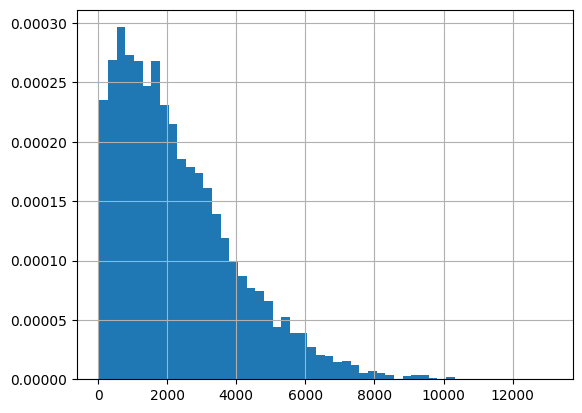

In [57]:
df['Item_Outlet_Sales'].hist(bins='auto', density=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Dairy'),
  Text(1, 0, 'Soft Drinks'),
  Text(2, 0, 'Meat'),
  Text(3, 0, 'Household'),
  Text(4, 0, 'Baking Goods'),
  Text(5, 0, 'Snack Foods'),
  Text(6, 0, 'Fruits and Vegetables'),
  Text(7, 0, 'Breakfast'),
  Text(8, 0, 'Health and Hygiene'),
  Text(9, 0, 'Hard Drinks'),
  Text(10, 0, 'Frozen Foods'),
  Text(11, 0, 'Canned'),
  Text(12, 0, 'Starchy Foods'),
  Text(13, 0, 'Breads'),
  Text(14, 0, 'Others'),
  Text(15, 0, 'Seafood')])

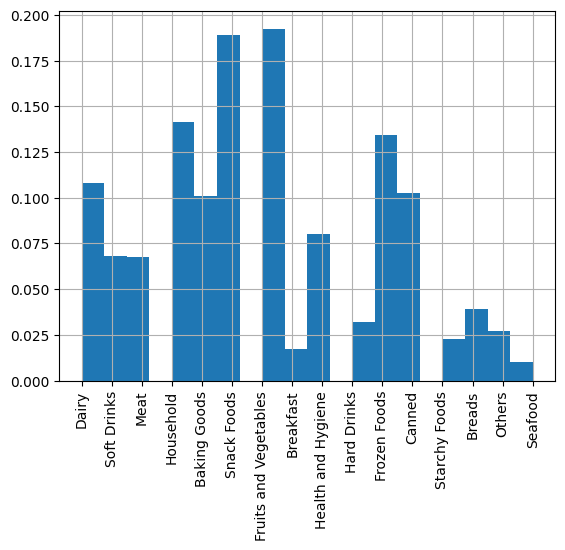

In [61]:
df['Item_Type'].hist(bins='auto', density=True)
plt.xticks(rotation=90)

<Axes: >

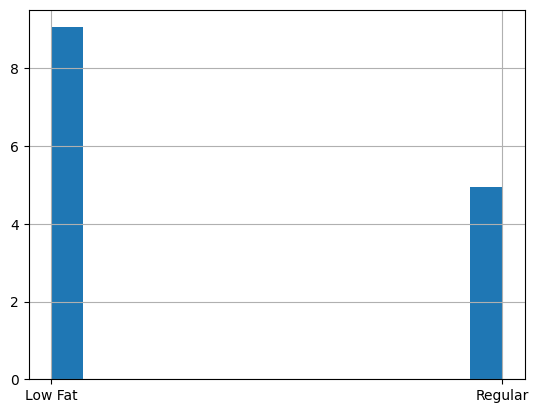

In [62]:
df['Item_Fat_Content'].hist(bins='auto', density=True)

<Axes: xlabel='Item_Weight'>

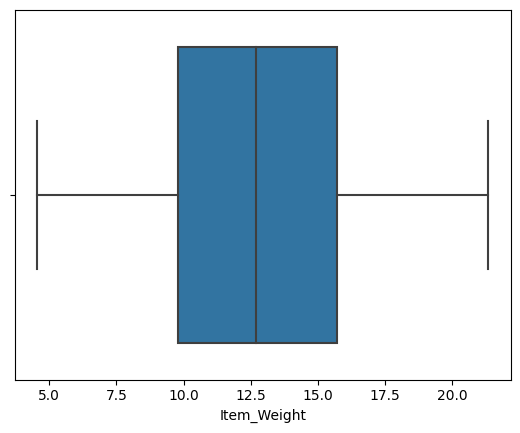

In [64]:
sns.boxplot(x='Item_Weight', data=df)

<Axes: xlabel='Item_Visibility'>

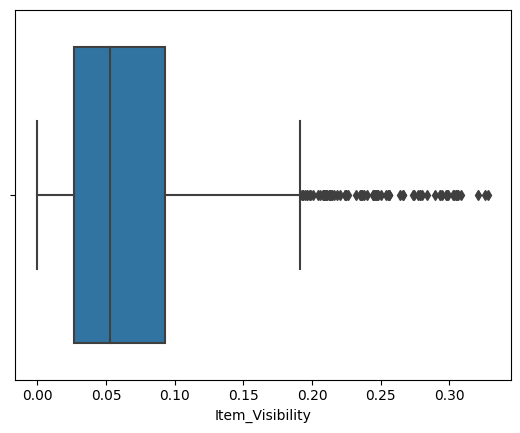

In [65]:
sns.boxplot(x='Item_Visibility', data=df)

<ipython-input-66-f45a1220306e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

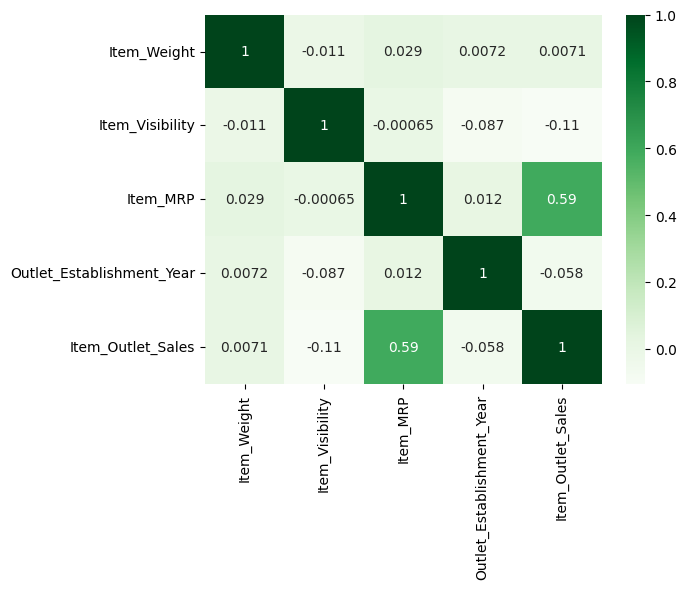

In [66]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens' ,annot = True )